In [7]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import optuna
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pandas_gbq import read_gbq
import datetime
import pytz


In [3]:
df = pd.read_pickle('cri_compustat_data.pkl')

# df = read_gbq(f"""

# SELECT *
# FROM capstone-402105.capstone.cri_compustat_data

# """,project_id='capstone-402105', dialect='standard')

In [8]:
cols = list(df.columns)

df.sort_values(by='EventDate', inplace=True)
date2022 = datetime.datetime(2022, 1, 1).replace(tzinfo=pytz.UTC)
date2020 = datetime.datetime(2020,1,1).replace(tzinfo=pytz.UTC)
train_df = df[df["EventDate"] < date2020]
validation_df = df[(df["EventDate"] >= date2020) & (df["EventDate"] < date2022)]
test_df = df[df["EventDate"] >= date2022]

In [9]:
train_df = train_df.drop(columns=['CompNo','year','month','StartDate','EventDate','Duration','tic', 'dummy297fin', 'gvkey'])
validation_df = validation_df.drop(columns=['CompNo','year','month','StartDate','EventDate','Duration','tic', 'dummy297fin', 'gvkey'])
test_df = test_df.drop(columns=['CompNo','year','month','StartDate','EventDate','Duration','tic', 'dummy297fin', 'gvkey'])

In [10]:
x_train = train_df.drop(['Default_1','Default_3','Default_6','Default_12','Default_24','Default_36','Default_60'], axis=1)
y_train = train_df['Default_12']
x_validation = validation_df.drop(['Default_1','Default_3','Default_6','Default_12','Default_24','Default_36','Default_60'], axis=1)
y_validation = validation_df['Default_12']
x_test = test_df.drop(['Default_1','Default_3','Default_6','Default_12','Default_24','Default_36','Default_60'], axis=1)
y_test = test_df["Default_12"]

In [12]:
x_train.shape

(1084578, 40)

In [11]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_validation_scaled = scaler.fit_transform(x_validation)
x_test_scaled = scaler.transform(x_test)

In [13]:
pca = PCA()
x_train_pca = pca.fit_transform(x_train_scaled)
x_validation_pca = pca.transform(x_validation_scaled)
x_test_pca = pca.transform(x_test_scaled)

In [14]:
explained_variance_ratio = pca.explained_variance_ratio_.cumsum()
n_components = np.argmax(explained_variance_ratio >= 0.95) + 1  # 95% of variance

x_train_pca = x_train_pca[:, :n_components]
x_validation_pca = x_validation_pca[:, :n_components]
x_test_pca = x_test_pca[:, :n_components]

In [15]:
x_train_pca.shape

(1084578, 31)

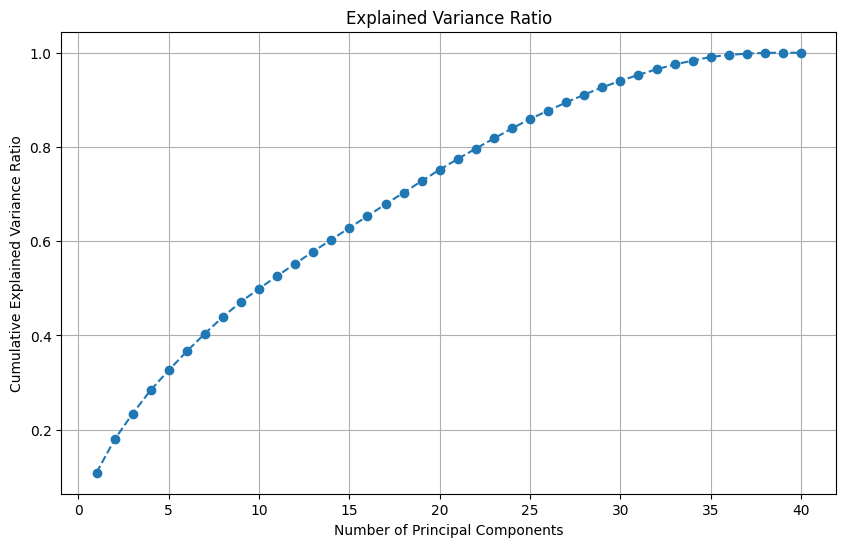

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.title('Explained Variance Ratio')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

In [18]:
# WARNING: 2 changes to change evaluation metric
optimisation_metric = "auc" #"accuracy" "recall" "precision" "f1" "auc"
def objective(trial):
    param = {
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'objective': 'binary',
        'metric': 'auc', #"accuracy" "recall" "precision" "f1" "auc"
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        # 'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        # 'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'learning_rate': trial.suggest_float('learning_rate', 1e-8, 10.0, log=True),
        'scale_pos_weight': 100,
        'max_depth': trial.suggest_int('max_depth', 2, 256),
        'num_boost_round': trial.suggest_int('num_boost_round', 100, 500),
    }
    
    # full data
    
    gbm = lgb.train(param, lgb.Dataset(x_train, y_train))
    
    preds = gbm.predict(x_validation)
    y_pred_binary = np.round(preds)
    
    auc = roc_auc_score(y_validation, preds)
    accuracy = accuracy_score(y_validation, y_pred_binary)
    recall = recall_score(y_validation, y_pred_binary)
    precision = precision_score(y_validation, y_pred_binary)
    f1 = f1_score(y_validation, y_pred_binary)
    
    #choose the metric you want to optimized
    if optimisation_metric == 'recall': 
        return recall
    elif optimisation_metric == 'precision': 
        return precision
    elif optimisation_metric == 'f1':
        return f1
    elif optimisation_metric == 'auc':
        return auc
    elif optimisation_metric == 'accuracy': 
        return accuracy
    return auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_params = study.best_params

[I 2023-11-08 17:38:19,011] A new study created in memory with name: no-name-5b0f1253-6088-49a2-8c2b-12da656c503f
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.139770 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leave

[I 2023-11-08 17:38:25,474] Trial 0 finished with value: 0.5 and parameters: {'num_leaves': 4, 'lambda_l1': 4.647886009575026, 'lambda_l2': 0.6784257374500378, 'feature_fraction': 0.9990166476523618, 'min_child_samples': 7, 'learning_rate': 9.899505390703068, 'max_depth': 199, 'num_boost_round': 210}. Best is trial 0 with value: 0.5.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.158605 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 17:38:41,868] Trial 1 finished with value: 0.9452833949365779 and parameters: {'num_leaves': 12, 'lambda_l1': 5.6537454992093526e-05, 'lambda_l2': 0.07382764101412291, 'feature_fraction': 0.7624339749857321, 'min_child_samples': 50, 'learning_rate': 4.884544862508462e-07, 'max_depth': 236, 'num_boost_round': 389}. Best is trial 1 with value: 0.9452833949365779.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.141666 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 17:38:55,951] Trial 2 finished with value: 0.9524312505826129 and parameters: {'num_leaves': 30, 'lambda_l1': 2.7465196365762243, 'lambda_l2': 4.885303100862461e-07, 'feature_fraction': 0.7520463590535234, 'min_child_samples': 79, 'learning_rate': 1.3143103633729942e-06, 'max_depth': 181, 'num_boost_round': 251}. Best is trial 2 with value: 0.9524312505826129.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.159311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 17:39:23,757] Trial 3 finished with value: 0.9622556873391742 and parameters: {'num_leaves': 54, 'lambda_l1': 6.319241488429802e-06, 'lambda_l2': 2.346286190065887, 'feature_fraction': 0.9907541270505765, 'min_child_samples': 12, 'learning_rate': 0.0021116801931266123, 'max_depth': 203, 'num_boost_round': 286}. Best is trial 3 with value: 0.9622556873391742.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.162629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 17:39:37,061] Trial 4 finished with value: 0.9539435882232614 and parameters: {'num_leaves': 40, 'lambda_l1': 0.2296272984192457, 'lambda_l2': 5.319532034748878e-05, 'feature_fraction': 0.9031250382705158, 'min_child_samples': 5, 'learning_rate': 0.0004493814182427834, 'max_depth': 171, 'num_boost_round': 179}. Best is trial 3 with value: 0.9622556873391742.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.164499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 17:40:23,378] Trial 5 finished with value: 0.9644333771334549 and parameters: {'num_leaves': 191, 'lambda_l1': 0.0001500157875754717, 'lambda_l2': 1.1917474113801044e-06, 'feature_fraction': 0.6410627912819551, 'min_child_samples': 72, 'learning_rate': 0.0011796929303311567, 'max_depth': 71, 'num_boost_round': 470}. Best is trial 5 with value: 0.9644333771334549.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014434 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 17:40:44,269] Trial 6 finished with value: 0.9729319396759022 and parameters: {'num_leaves': 130, 'lambda_l1': 6.895018245951259e-06, 'lambda_l2': 6.56173301012467e-07, 'feature_fraction': 0.5286903315825886, 'min_child_samples': 50, 'learning_rate': 0.018322953349056523, 'max_depth': 224, 'num_boost_round': 280}. Best is trial 6 with value: 0.9729319396759022.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.115153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split require

[I 2023-11-08 17:40:54,304] Trial 7 finished with value: 0.5238052641793525 and parameters: {'num_leaves': 196, 'lambda_l1': 7.191101855159944e-07, 'lambda_l2': 0.00015726462386054, 'feature_fraction': 0.709736940906587, 'min_child_samples': 42, 'learning_rate': 5.235955723479008, 'max_depth': 246, 'num_boost_round': 349}. Best is trial 6 with value: 0.9729319396759022.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.126113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 17:41:05,967] Trial 8 finished with value: 0.95786327703646 and parameters: {'num_leaves': 138, 'lambda_l1': 9.397266959070823e-06, 'lambda_l2': 3.5875439691463604e-07, 'feature_fraction': 0.7268707522610247, 'min_child_samples': 44, 'learning_rate': 1.9463624515951503e-07, 'max_depth': 81, 'num_boost_round': 142}. Best is trial 6 with value: 0.9729319396759022.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.135110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 17:41:32,981] Trial 9 finished with value: 0.9565123245420908 and parameters: {'num_leaves': 49, 'lambda_l1': 0.00025945818407590573, 'lambda_l2': 1.867681631107234e-05, 'feature_fraction': 0.938545555776956, 'min_child_samples': 72, 'learning_rate': 2.9027058530882e-05, 'max_depth': 223, 'num_boost_round': 389}. Best is trial 6 with value: 0.9729319396759022.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.117197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 17:41:40,924] Trial 10 finished with value: 0.8160526153780997 and parameters: {'num_leaves': 247, 'lambda_l1': 1.8240580338354348e-08, 'lambda_l2': 1.1053444289048484e-08, 'feature_fraction': 0.464489927937275, 'min_child_samples': 97, 'learning_rate': 0.18449705859176535, 'max_depth': 23, 'num_boost_round': 110}. Best is trial 6 with value: 0.9729319396759022.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.107900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 17:42:14,320] Trial 11 finished with value: 0.9727690809418823 and parameters: {'num_leaves': 135, 'lambda_l1': 0.002792607388356807, 'lambda_l2': 2.406632139304488e-06, 'feature_fraction': 0.5553536455200401, 'min_child_samples': 69, 'learning_rate': 0.018011574095144298, 'max_depth': 111, 'num_boost_round': 495}. Best is trial 6 with value: 0.9729319396759022.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.133386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 17:42:41,932] Trial 12 finished with value: 0.9733794737305151 and parameters: {'num_leaves': 107, 'lambda_l1': 0.0023099918589210297, 'lambda_l2': 0.000990656181202312, 'feature_fraction': 0.4909817202192156, 'min_child_samples': 34, 'learning_rate': 0.03941468697487067, 'max_depth': 129, 'num_boost_round': 497}. Best is trial 12 with value: 0.9733794737305151.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.131654 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 17:42:58,564] Trial 13 finished with value: 0.9652597323921001 and parameters: {'num_leaves': 91, 'lambda_l1': 0.005931006716432809, 'lambda_l2': 0.003022180483812939, 'feature_fraction': 0.43696629927128794, 'min_child_samples': 29, 'learning_rate': 0.07345913822095536, 'max_depth': 149, 'num_boost_round': 337}. Best is trial 12 with value: 0.9733794737305151.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.101526 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 17:43:25,781] Trial 14 finished with value: 0.9598431786095313 and parameters: {'num_leaves': 100, 'lambda_l1': 0.006487705347599413, 'lambda_l2': 0.001790776500089622, 'feature_fraction': 0.5266242417715411, 'min_child_samples': 28, 'learning_rate': 6.0636293045275105e-05, 'max_depth': 126, 'num_boost_round': 407}. Best is trial 12 with value: 0.9733794737305151.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125617 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 17:43:45,591] Trial 15 finished with value: 0.9674252514431881 and parameters: {'num_leaves': 168, 'lambda_l1': 3.207990383688194e-07, 'lambda_l2': 0.0018883950900529622, 'feature_fraction': 0.4272912597150093, 'min_child_samples': 32, 'learning_rate': 0.011905244700435335, 'max_depth': 93, 'num_boost_round': 271}. Best is trial 12 with value: 0.9733794737305151.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.137177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there 

[I 2023-11-08 17:43:57,294] Trial 16 finished with value: 0.8066590393037505 and parameters: {'num_leaves': 89, 'lambda_l1': 0.0006935135012729051, 'lambda_l2': 1.4121335794097465e-05, 'feature_fraction': 0.536446214083162, 'min_child_samples': 60, 'learning_rate': 0.41314697167432485, 'max_depth': 42, 'num_boost_round': 225}. Best is trial 12 with value: 0.9733794737305151.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.115899 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 17:44:28,438] Trial 17 finished with value: 0.958249793643139 and parameters: {'num_leaves': 116, 'lambda_l1': 0.024116560722409405, 'lambda_l2': 0.027066129745299934, 'feature_fraction': 0.6293570840768319, 'min_child_samples': 21, 'learning_rate': 2.339473243315862e-08, 'max_depth': 151, 'num_boost_round': 444}. Best is trial 12 with value: 0.9733794737305151.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.102142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 17:44:55,380] Trial 18 finished with value: 0.9688009274652086 and parameters: {'num_leaves': 178, 'lambda_l1': 5.0472036249444914e-05, 'lambda_l2': 0.00011532546036341675, 'feature_fraction': 0.480036809838119, 'min_child_samples': 56, 'learning_rate': 0.007798468264168522, 'max_depth': 156, 'num_boost_round': 325}. Best is trial 12 with value: 0.9733794737305151.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.117690 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 17:45:12,575] Trial 19 finished with value: 0.6769949157948304 and parameters: {'num_leaves': 72, 'lambda_l1': 0.1369200669933049, 'lambda_l2': 9.717047811836697, 'feature_fraction': 0.42026760350920944, 'min_child_samples': 38, 'learning_rate': 0.4305840440181434, 'max_depth': 255, 'num_boost_round': 437}. Best is trial 12 with value: 0.9733794737305151.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.129200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 17:45:38,165] Trial 20 finished with value: 0.962398952813974 and parameters: {'num_leaves': 150, 'lambda_l1': 0.00038097325586249065, 'lambda_l2': 0.0005098614969796984, 'feature_fraction': 0.6063354835464473, 'min_child_samples': 20, 'learning_rate': 9.230682417552235e-05, 'max_depth': 112, 'num_boost_round': 304}. Best is trial 12 with value: 0.9733794737305151.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.132037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 17:46:10,896] Trial 21 finished with value: 0.9699703012035173 and parameters: {'num_leaves': 123, 'lambda_l1': 0.002847752563089692, 'lambda_l2': 5.899946919415168e-06, 'feature_fraction': 0.5361036662616476, 'min_child_samples': 64, 'learning_rate': 0.028119476666705227, 'max_depth': 104, 'num_boost_round': 499}. Best is trial 12 with value: 0.9733794737305151.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 17:46:49,631] Trial 22 finished with value: 0.9686914999311235 and parameters: {'num_leaves': 146, 'lambda_l1': 0.0011946114050184044, 'lambda_l2': 5.7829768441478014e-08, 'feature_fraction': 0.4922946645940415, 'min_child_samples': 86, 'learning_rate': 0.005212793572318805, 'max_depth': 56, 'num_boost_round': 472}. Best is trial 12 with value: 0.9733794737305151.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.137734 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 17:47:27,229] Trial 23 finished with value: 0.9720791689925703 and parameters: {'num_leaves': 215, 'lambda_l1': 0.030561904608674955, 'lambda_l2': 4.4259910979454665e-06, 'feature_fraction': 0.580886446316973, 'min_child_samples': 48, 'learning_rate': 0.037334404614682515, 'max_depth': 127, 'num_boost_round': 498}. Best is trial 12 with value: 0.9733794737305151.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.130434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 17:47:53,897] Trial 24 finished with value: 0.9630942679183357 and parameters: {'num_leaves': 113, 'lambda_l1': 0.001587198061643179, 'lambda_l2': 1.857731897667956e-06, 'feature_fraction': 0.5678193543330341, 'min_child_samples': 67, 'learning_rate': 0.001604457244449845, 'max_depth': 139, 'num_boost_round': 368}. Best is trial 12 with value: 0.9733794737305151.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014809 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 17:48:21,451] Trial 25 finished with value: 0.9189997199091746 and parameters: {'num_leaves': 157, 'lambda_l1': 2.7997542081715734e-05, 'lambda_l2': 2.882682592318183e-05, 'feature_fraction': 0.5088589033891951, 'min_child_samples': 56, 'learning_rate': 0.10229256334642671, 'max_depth': 114, 'num_boost_round': 427}. Best is trial 12 with value: 0.9733794737305151.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2023-11-08 17:48:36,999] Trial 26 finished with value: 0.8104312056108982 and parameters: {'num_leaves': 75, 'lambda_l1': 0.0006070333088763193, 'lambda_l2': 1.316950646326018e-07, 'feature_fraction': 0.408030303154579, 'min_child_samples': 36, 'learning_rate': 0.9611684496679911, 'max_depth': 5, 'num_boost_round': 462}. Best is trial 12 with value: 0.9733794737305151.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.114332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 17:48:53,041] Trial 27 finished with value: 0.9720095283274867 and parameters: {'num_leaves': 132, 'lambda_l1': 0.00013822269007519346, 'lambda_l2': 1.3756053039766132e-06, 'feature_fraction': 0.46957317503426943, 'min_child_samples': 83, 'learning_rate': 0.038745263777411075, 'max_depth': 172, 'num_boost_round': 249}. Best is trial 12 with value: 0.9733794737305151.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.112165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 17:49:17,797] Trial 28 finished with value: 0.9708535533221544 and parameters: {'num_leaves': 106, 'lambda_l1': 0.010564481614550416, 'lambda_l2': 5.58607057758562e-06, 'feature_fraction': 0.6720083575868208, 'min_child_samples': 45, 'learning_rate': 0.010012564052445844, 'max_depth': 205, 'num_boost_round': 302}. Best is trial 12 with value: 0.9733794737305151.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.142437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 17:49:30,722] Trial 29 finished with value: 0.9620602732315473 and parameters: {'num_leaves': 76, 'lambda_l1': 0.001256208284841686, 'lambda_l2': 0.0002480946093235307, 'feature_fraction': 0.5691334952218556, 'min_child_samples': 54, 'learning_rate': 0.0038768640310557073, 'max_depth': 187, 'num_boost_round': 180}. Best is trial 12 with value: 0.9733794737305151.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.101269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leave

[I 2023-11-08 17:49:41,414] Trial 30 finished with value: 0.8011695156393503 and parameters: {'num_leaves': 164, 'lambda_l1': 1.0865538825340242e-05, 'lambda_l2': 4.683748795737977e-05, 'feature_fraction': 0.5050052205696016, 'min_child_samples': 94, 'learning_rate': 2.4218694870280406, 'max_depth': 81, 'num_boost_round': 409}. Best is trial 12 with value: 0.9733794737305151.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.107115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 17:50:20,691] Trial 31 finished with value: 0.9705516042786002 and parameters: {'num_leaves': 218, 'lambda_l1': 0.05537632718516259, 'lambda_l2': 4.986684051275827e-06, 'feature_fraction': 0.5791070402113868, 'min_child_samples': 48, 'learning_rate': 0.023902184701931863, 'max_depth': 129, 'num_boost_round': 497}. Best is trial 12 with value: 0.9733794737305151.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.144637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 17:50:58,549] Trial 32 finished with value: 0.9692921779561315 and parameters: {'num_leaves': 253, 'lambda_l1': 0.029555108845736987, 'lambda_l2': 1.760121498128212e-07, 'feature_fraction': 0.5538528006111461, 'min_child_samples': 50, 'learning_rate': 0.052873668381074324, 'max_depth': 124, 'num_boost_round': 498}. Best is trial 12 with value: 0.9733794737305151.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.158579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2023-11-08 17:51:21,727] Trial 33 finished with value: 0.8250850805899677 and parameters: {'num_leaves': 225, 'lambda_l1': 0.5682131470158152, 'lambda_l2': 7.747589211222704e-07, 'feature_fraction': 0.6086195777187571, 'min_child_samples': 39, 'learning_rate': 0.17371478576159016, 'max_depth': 162, 'num_boost_round': 461}. Best is trial 12 with value: 0.9733794737305151.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.119948 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No

[I 2023-11-08 17:51:32,693] Trial 34 finished with value: 0.7761077996016729 and parameters: {'num_leaves': 210, 'lambda_l1': 7.556031815507314, 'lambda_l2': 5.435390926901871e-06, 'feature_fraction': 0.5936096730645899, 'min_child_samples': 63, 'learning_rate': 1.0452974956919756, 'max_depth': 99, 'num_boost_round': 372}. Best is trial 12 with value: 0.9733794737305151.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.118988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 17:51:51,655] Trial 35 finished with value: 0.9708977336657166 and parameters: {'num_leaves': 23, 'lambda_l1': 0.003711569069780781, 'lambda_l2': 2.268629457892801e-06, 'feature_fraction': 0.527669750116174, 'min_child_samples': 72, 'learning_rate': 0.013677015817306154, 'max_depth': 219, 'num_boost_round': 475}. Best is trial 12 with value: 0.9733794737305151.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.140792 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 17:52:32,191] Trial 36 finished with value: 0.9632227156497419 and parameters: {'num_leaves': 185, 'lambda_l1': 0.018509168971343568, 'lambda_l2': 6.159470005056085e-07, 'feature_fraction': 0.6673717997434863, 'min_child_samples': 20, 'learning_rate': 0.0006984824561700482, 'max_depth': 139, 'num_boost_round': 423}. Best is trial 12 with value: 0.9733794737305151.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.120649 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leave

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 17:52:43,958] Trial 37 finished with value: 0.5 and parameters: {'num_leaves': 131, 'lambda_l1': 0.07625655396537862, 'lambda_l2': 1.2041527431958446e-05, 'feature_fraction': 0.45345232814859027, 'min_child_samples': 13, 'learning_rate': 9.815801904691975, 'max_depth': 184, 'num_boost_round': 449}. Best is trial 12 with value: 0.9733794737305151.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.104626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 17:53:25,369] Trial 38 finished with value: 0.966912552064038 and parameters: {'num_leaves': 233, 'lambda_l1': 0.5764591787776373, 'lambda_l2': 3.4499943192678267e-05, 'feature_fraction': 0.5012547973941465, 'min_child_samples': 78, 'learning_rate': 0.002335733460267808, 'max_depth': 62, 'num_boost_round': 481}. Best is trial 12 with value: 0.9733794737305151.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.107807 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 17:53:30,729] Trial 39 finished with value: 0.9397777163843528 and parameters: {'num_leaves': 2, 'lambda_l1': 0.00012769861158737957, 'lambda_l2': 5.117869922438857e-07, 'feature_fraction': 0.559654063039754, 'min_child_samples': 49, 'learning_rate': 0.00048184211555645645, 'max_depth': 91, 'num_boost_round': 273}. Best is trial 12 with value: 0.9733794737305151.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.120872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 17:53:50,028] Trial 40 finished with value: 0.9631504279844573 and parameters: {'num_leaves': 200, 'lambda_l1': 0.009737525294385605, 'lambda_l2': 7.207922557716908e-05, 'feature_fraction': 0.6282259014547312, 'min_child_samples': 34, 'learning_rate': 0.03970585119226397, 'max_depth': 140, 'num_boost_round': 223}. Best is trial 12 with value: 0.9733794737305151.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.114847 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 17:54:07,453] Trial 41 finished with value: 0.9727677710861128 and parameters: {'num_leaves': 132, 'lambda_l1': 0.00015333471282330676, 'lambda_l2': 1.2386499741117574e-06, 'feature_fraction': 0.4667720700662923, 'min_child_samples': 87, 'learning_rate': 0.029570486417826357, 'max_depth': 167, 'num_boost_round': 254}. Best is trial 12 with value: 0.9733794737305151.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.121521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 17:54:19,470] Trial 42 finished with value: 0.8160034412094159 and parameters: {'num_leaves': 139, 'lambda_l1': 0.002972860442716431, 'lambda_l2': 2.487327256310675e-07, 'feature_fraction': 0.4529834350313631, 'min_child_samples': 87, 'learning_rate': 0.13611451291195306, 'max_depth': 199, 'num_boost_round': 247}. Best is trial 12 with value: 0.9733794737305151.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.111238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 17:54:42,318] Trial 43 finished with value: 0.9649408370895266 and parameters: {'num_leaves': 122, 'lambda_l1': 0.0003393122357727606, 'lambda_l2': 3.4826582905805045e-06, 'feature_fraction': 0.4820358155418797, 'min_child_samples': 100, 'learning_rate': 0.00416963609792574, 'max_depth': 234, 'num_boost_round': 321}. Best is trial 12 with value: 0.9733794737305151.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.110993 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 17:54:53,198] Trial 44 finished with value: 0.9663919389729464 and parameters: {'num_leaves': 59, 'lambda_l1': 5.908638498163797e-05, 'lambda_l2': 1.087426713088048e-06, 'feature_fraction': 0.4029663876337466, 'min_child_samples': 77, 'learning_rate': 0.013738443300143729, 'max_depth': 116, 'num_boost_round': 197}. Best is trial 12 with value: 0.9733794737305151.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.138950 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 17:55:10,183] Trial 45 finished with value: 0.9661540909961169 and parameters: {'num_leaves': 95, 'lambda_l1': 3.1320050386972645e-06, 'lambda_l2': 5.828969216147435e-08, 'feature_fraction': 0.5189990224180745, 'min_child_samples': 91, 'learning_rate': 0.06158658223488663, 'max_depth': 166, 'num_boost_round': 279}. Best is trial 12 with value: 0.9733794737305151.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.126018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 17:55:22,893] Trial 46 finished with value: 0.9612906511009229 and parameters: {'num_leaves': 169, 'lambda_l1': 0.0008333043164230307, 'lambda_l2': 1.309284449255939e-05, 'feature_fraction': 0.5432757816864301, 'min_child_samples': 45, 'learning_rate': 0.0014400214931595892, 'max_depth': 144, 'num_boost_round': 142}. Best is trial 12 with value: 0.9733794737305151.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.135276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2023-11-08 17:55:41,184] Trial 47 finished with value: 0.7972144607203727 and parameters: {'num_leaves': 148, 'lambda_l1': 0.000288546953713146, 'lambda_l2': 1.8093635530423756e-06, 'feature_fraction': 0.47859162156790824, 'min_child_samples': 59, 'learning_rate': 0.2659320163770477, 'max_depth': 173, 'num_boost_round': 485}. Best is trial 12 with value: 0.9733794737305151.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.139362 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 17:55:55,591] Trial 48 finished with value: 0.9720560282073073 and parameters: {'num_leaves': 106, 'lambda_l1': 0.0066417932549744044, 'lambda_l2': 9.696562832951539e-05, 'feature_fraction': 0.4457590910816269, 'min_child_samples': 68, 'learning_rate': 0.02292240409853155, 'max_depth': 217, 'num_boost_round': 235}. Best is trial 12 with value: 0.9733794737305151.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.105621 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 17:56:13,091] Trial 49 finished with value: 0.9579478991769086 and parameters: {'num_leaves': 182, 'lambda_l1': 0.0017665344873589377, 'lambda_l2': 3.8842092269476606e-07, 'feature_fraction': 0.5843568009591857, 'min_child_samples': 41, 'learning_rate': 0.08450540310813515, 'max_depth': 82, 'num_boost_round': 262}. Best is trial 12 with value: 0.9733794737305151.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-08 17:56:31,700] Trial 50 finished with value: 0.9600415398926399 and parameters: {'num_leaves': 84, 'lambda_l1': 0.018553387753568875, 'lambda_l2': 0.0004672773073664455, 'feature_fraction': 0.5125041702930225, 'min_child_samples': 26, 'learning_rate': 0.00024198484317619555, 'max_depth': 237, 'num_boost_round': 289}. Best is trial 12 with value: 0.9733794737305151.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.103193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 17:56:45,739] Trial 51 finished with value: 0.9709365381428908 and parameters: {'num_leaves': 104, 'lambda_l1': 0.005911971499275207, 'lambda_l2': 0.0001065418379582612, 'feature_fraction': 0.4377294767769547, 'min_child_samples': 68, 'learning_rate': 0.017235472727879987, 'max_depth': 217, 'num_boost_round': 230}. Best is trial 12 with value: 0.9733794737305151.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 17:57:01,369] Trial 52 finished with value: 0.964412883348393 and parameters: {'num_leaves': 114, 'lambda_l1': 0.004857446363516437, 'lambda_l2': 1.3037455625314425e-05, 'feature_fraction': 0.4448058681095937, 'min_child_samples': 52, 'learning_rate': 0.0063830490529632805, 'max_depth': 211, 'num_boost_round': 240}. Best is trial 12 with value: 0.9733794737305151.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.146310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 17:57:12,140] Trial 53 finished with value: 0.9718362453246336 and parameters: {'num_leaves': 63, 'lambda_l1': 0.002277957114266976, 'lambda_l2': 0.0001965659125959305, 'feature_fraction': 0.4653243492061935, 'min_child_samples': 59, 'learning_rate': 0.028849414912362446, 'max_depth': 191, 'num_boost_round': 201}. Best is trial 12 with value: 0.9733794737305151.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 17:57:26,793] Trial 54 finished with value: 0.927023459735143 and parameters: {'num_leaves': 125, 'lambda_l1': 0.0006444467663057397, 'lambda_l2': 0.0009261128313392501, 'feature_fraction': 0.4255386530136639, 'min_child_samples': 74, 'learning_rate': 0.11290250211148156, 'max_depth': 233, 'num_boost_round': 262}. Best is trial 12 with value: 0.9733794737305151.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014959 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2023-11-08 17:57:44,354] Trial 55 finished with value: 0.8207223603513644 and parameters: {'num_leaves': 135, 'lambda_l1': 0.010579252206031129, 'lambda_l2': 5.480376930268166e-05, 'feature_fraction': 0.4912196326468853, 'min_child_samples': 66, 'learning_rate': 0.24558562191436467, 'max_depth': 249, 'num_boost_round': 318}. Best is trial 12 with value: 0.9733794737305151.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.115682 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 17:57:59,208] Trial 56 finished with value: 0.9695543674193461 and parameters: {'num_leaves': 107, 'lambda_l1': 0.03417415531786236, 'lambda_l2': 2.656796977973701e-06, 'feature_fraction': 0.5379811302818986, 'min_child_samples': 31, 'learning_rate': 0.00984966459898799, 'max_depth': 122, 'num_boost_round': 213}. Best is trial 12 with value: 0.9733794737305151.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012670 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 17:58:26,284] Trial 57 finished with value: 0.9647183253406663 and parameters: {'num_leaves': 157, 'lambda_l1': 0.0038152866250756364, 'lambda_l2': 0.007858013137030322, 'feature_fraction': 0.46230955102866567, 'min_child_samples': 71, 'learning_rate': 0.0023963496555642716, 'max_depth': 133, 'num_boost_round': 356}. Best is trial 12 with value: 0.9733794737305151.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.110485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 17:58:43,488] Trial 58 finished with value: 0.9721017640045957 and parameters: {'num_leaves': 40, 'lambda_l1': 0.00017573069634359872, 'lambda_l2': 8.695675339662235e-06, 'feature_fraction': 0.5148390932018111, 'min_child_samples': 83, 'learning_rate': 0.05173096229289403, 'max_depth': 152, 'num_boost_round': 451}. Best is trial 12 with value: 0.9733794737305151.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.138022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 17:59:01,164] Trial 59 finished with value: 0.9677404900650715 and parameters: {'num_leaves': 46, 'lambda_l1': 0.00021394125554350274, 'lambda_l2': 1.0295201754797716e-06, 'feature_fraction': 0.550719875104009, 'min_child_samples': 84, 'learning_rate': 0.0669880198119512, 'max_depth': 151, 'num_boost_round': 458}. Best is trial 12 with value: 0.9733794737305151.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014839 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[Ligh

[I 2023-11-08 17:59:19,337] Trial 60 finished with value: 0.7557692051598712 and parameters: {'num_leaves': 34, 'lambda_l1': 7.65265894536375e-05, 'lambda_l2': 2.0121853136066e-05, 'feature_fraction': 0.521650616644031, 'min_child_samples': 91, 'learning_rate': 0.8599885409263853, 'max_depth': 107, 'num_boost_round': 488}. Best is trial 12 with value: 0.9733794737305151.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.100620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 17:59:34,221] Trial 61 finished with value: 0.9739810249927031 and parameters: {'num_leaves': 22, 'lambda_l1': 0.00057974368200517, 'lambda_l2': 8.032501585193775e-06, 'feature_fraction': 0.4928192954765598, 'min_child_samples': 81, 'learning_rate': 0.033613095835607856, 'max_depth': 155, 'num_boost_round': 441}. Best is trial 61 with value: 0.9739810249927031.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.116035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 17:59:49,064] Trial 62 finished with value: 0.9699136499414821 and parameters: {'num_leaves': 23, 'lambda_l1': 0.0008696784747398311, 'lambda_l2': 6.246481470457207e-06, 'feature_fraction': 0.4987287974742722, 'min_child_samples': 80, 'learning_rate': 0.03770618106286342, 'max_depth': 160, 'num_boost_round': 441}. Best is trial 61 with value: 0.9739810249927031.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.107390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 18:00:05,040] Trial 63 finished with value: 0.9645511549980712 and parameters: {'num_leaves': 18, 'lambda_l1': 3.622742480203393e-05, 'lambda_l2': 2.9994126177934098e-06, 'feature_fraction': 0.5644960585546327, 'min_child_samples': 82, 'learning_rate': 0.006844486760740046, 'max_depth': 175, 'num_boost_round': 408}. Best is trial 61 with value: 0.9739810249927031.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.103947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 18:00:16,699] Trial 64 finished with value: 0.9001689059014897 and parameters: {'num_leaves': 13, 'lambda_l1': 0.0004185574710200748, 'lambda_l2': 9.183816388346314e-06, 'feature_fraction': 0.482714612211587, 'min_child_samples': 89, 'learning_rate': 0.11859469922697301, 'max_depth': 130, 'num_boost_round': 468}. Best is trial 61 with value: 0.9739810249927031.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.139146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 18:00:33,161] Trial 65 finished with value: 0.9721802189074623 and parameters: {'num_leaves': 30, 'lambda_l1': 0.00017116795966378855, 'lambda_l2': 1.5802496420838419e-06, 'feature_fraction': 0.5233232681184825, 'min_child_samples': 76, 'learning_rate': 0.01666422885873688, 'max_depth': 152, 'num_boost_round': 394}. Best is trial 61 with value: 0.9739810249927031.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.132980 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 18:00:52,411] Trial 66 finished with value: 0.973625399151257 and parameters: {'num_leaves': 39, 'lambda_l1': 0.0001409387184764743, 'lambda_l2': 1.0440715200439745e-06, 'feature_fraction': 0.5203291092215878, 'min_child_samples': 75, 'learning_rate': 0.0202196949750275, 'max_depth': 152, 'num_boost_round': 435}. Best is trial 61 with value: 0.9739810249927031.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.130986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 18:01:09,597] Trial 67 finished with value: 0.9713798151662524 and parameters: {'num_leaves': 33, 'lambda_l1': 3.0612189228104524e-05, 'lambda_l2': 7.69777583855225e-07, 'feature_fraction': 0.5378068855035045, 'min_child_samples': 73, 'learning_rate': 0.016256951160119323, 'max_depth': 146, 'num_boost_round': 395}. Best is trial 61 with value: 0.9739810249927031.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 18:01:32,984] Trial 68 finished with value: 0.9676667833893697 and parameters: {'num_leaves': 46, 'lambda_l1': 9.758825173778294e-05, 'lambda_l2': 3.582561603434347e-07, 'feature_fraction': 0.4979532288079832, 'min_child_samples': 77, 'learning_rate': 0.006907270738414764, 'max_depth': 178, 'num_boost_round': 423}. Best is trial 61 with value: 0.9739810249927031.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.108092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 18:02:02,455] Trial 69 finished with value: 0.965959686568979 and parameters: {'num_leaves': 142, 'lambda_l1': 1.807414044254723e-05, 'lambda_l2': 1.5120738905196808e-06, 'feature_fraction': 0.4648328813439954, 'min_child_samples': 62, 'learning_rate': 0.0037991582070548125, 'max_depth': 192, 'num_boost_round': 431}. Best is trial 61 with value: 0.9739810249927031.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.108165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2023-11-08 18:02:12,903] Trial 70 finished with value: 0.7435892929769681 and parameters: {'num_leaves': 10, 'lambda_l1': 0.0004662148765457842, 'lambda_l2': 1.1380768184574209e-07, 'feature_fraction': 0.5281945697200047, 'min_child_samples': 95, 'learning_rate': 0.372090428135437, 'max_depth': 167, 'num_boost_round': 395}. Best is trial 61 with value: 0.9739810249927031.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013613 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 18:02:33,135] Trial 71 finished with value: 0.9737511453051386 and parameters: {'num_leaves': 41, 'lambda_l1': 0.0001482537960546575, 'lambda_l2': 2.7499876332377323e-05, 'feature_fraction': 0.5140473249039257, 'min_child_samples': 85, 'learning_rate': 0.046632739462454754, 'max_depth': 156, 'num_boost_round': 416}. Best is trial 61 with value: 0.9739810249927031.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.103330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 18:02:48,008] Trial 72 finished with value: 0.9708699538079363 and parameters: {'num_leaves': 23, 'lambda_l1': 0.0001746597393817287, 'lambda_l2': 1.8720421683019564e-05, 'feature_fraction': 0.5531691415509544, 'min_child_samples': 75, 'learning_rate': 0.013990520562407063, 'max_depth': 158, 'num_boost_round': 378}. Best is trial 61 with value: 0.9739810249927031.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.103321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 18:03:06,723] Trial 73 finished with value: 0.9744224463870576 and parameters: {'num_leaves': 56, 'lambda_l1': 0.0011952522181821305, 'lambda_l2': 2.0033078445812916e-06, 'feature_fraction': 0.4792868820058066, 'min_child_samples': 86, 'learning_rate': 0.027113147401719953, 'max_depth': 136, 'num_boost_round': 416}. Best is trial 73 with value: 0.9744224463870576.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.106468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 18:03:26,639] Trial 74 finished with value: 0.9733955194636925 and parameters: {'num_leaves': 68, 'lambda_l1': 0.0012767836177647975, 'lambda_l2': 2.6812365202778583e-06, 'feature_fraction': 0.4814507912080476, 'min_child_samples': 80, 'learning_rate': 0.02782370104314433, 'max_depth': 135, 'num_boost_round': 416}. Best is trial 73 with value: 0.9744224463870576.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.109443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 18:03:42,365] Trial 75 finished with value: 0.8716584760657695 and parameters: {'num_leaves': 54, 'lambda_l1': 0.0016092908038493692, 'lambda_l2': 2.81185558305659e-05, 'feature_fraction': 0.4889861973777223, 'min_child_samples': 81, 'learning_rate': 0.17167114475678674, 'max_depth': 119, 'num_boost_round': 415}. Best is trial 73 with value: 0.9744224463870576.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.104427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 18:03:56,856] Trial 76 finished with value: 0.9718769600081386 and parameters: {'num_leaves': 67, 'lambda_l1': 0.0008826883891626197, 'lambda_l2': 3.7755221894234157e-06, 'feature_fraction': 0.4284739153544349, 'min_child_samples': 91, 'learning_rate': 0.0629584765123142, 'max_depth': 107, 'num_boost_round': 343}. Best is trial 73 with value: 0.9744224463870576.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.102290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 18:04:16,695] Trial 77 finished with value: 0.974081883886962 and parameters: {'num_leaves': 78, 'lambda_l1': 0.0013152481293702215, 'lambda_l2': 6.318782214925836e-07, 'feature_fraction': 0.5067556225296886, 'min_child_samples': 86, 'learning_rate': 0.0253178554113033, 'max_depth': 134, 'num_boost_round': 381}. Best is trial 73 with value: 0.9744224463870576.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.109698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 18:04:33,466] Trial 78 finished with value: 0.9707103151360165 and parameters: {'num_leaves': 79, 'lambda_l1': 0.001344698536180227, 'lambda_l2': 4.652226727245761e-07, 'feature_fraction': 0.47572875963140104, 'min_child_samples': 86, 'learning_rate': 0.08054767435180862, 'max_depth': 134, 'num_boost_round': 383}. Best is trial 73 with value: 0.9744224463870576.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 18:04:53,154] Trial 79 finished with value: 0.9744978176711333 and parameters: {'num_leaves': 53, 'lambda_l1': 0.0004161984103068801, 'lambda_l2': 8.088266153037331e-07, 'feature_fraction': 0.5056307732447901, 'min_child_samples': 94, 'learning_rate': 0.025055866988531638, 'max_depth': 140, 'num_boost_round': 364}. Best is trial 79 with value: 0.9744978176711333.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.102099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 18:05:11,416] Trial 80 finished with value: 0.9732777415990763 and parameters: {'num_leaves': 69, 'lambda_l1': 0.00045302661032635086, 'lambda_l2': 2.830628847917142e-06, 'feature_fraction': 0.5060304280746006, 'min_child_samples': 99, 'learning_rate': 0.024879522714972485, 'max_depth': 140, 'num_boost_round': 361}. Best is trial 79 with value: 0.9744978176711333.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014650 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 18:05:30,957] Trial 81 finished with value: 0.9723979551404962 and parameters: {'num_leaves': 55, 'lambda_l1': 0.00046718702821688704, 'lambda_l2': 2.382034454467283e-06, 'feature_fraction': 0.5076532325719302, 'min_child_samples': 100, 'learning_rate': 0.019963853231309732, 'max_depth': 140, 'num_boost_round': 351}. Best is trial 79 with value: 0.9744978176711333.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014802 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 18:05:50,886] Trial 82 finished with value: 0.9720166779568956 and parameters: {'num_leaves': 67, 'lambda_l1': 0.0021346956666934806, 'lambda_l2': 7.596816358326871e-06, 'feature_fraction': 0.49481395118451355, 'min_child_samples': 97, 'learning_rate': 0.04014557320053655, 'max_depth': 145, 'num_boost_round': 363}. Best is trial 79 with value: 0.9744978176711333.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.122969 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 18:06:09,198] Trial 83 finished with value: 0.9687914582995409 and parameters: {'num_leaves': 41, 'lambda_l1': 0.00031099633404024893, 'lambda_l2': 7.9237032623957e-07, 'feature_fraction': 0.4572712548069961, 'min_child_samples': 94, 'learning_rate': 0.009103149997870272, 'max_depth': 137, 'num_boost_round': 402}. Best is trial 79 with value: 0.9744978176711333.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.107570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 18:06:26,687] Trial 84 finished with value: 0.9749778252333672 and parameters: {'num_leaves': 81, 'lambda_l1': 0.0012162963999560836, 'lambda_l2': 4.989289141547352e-06, 'feature_fraction': 0.4769782099910172, 'min_child_samples': 97, 'learning_rate': 0.02909109413463199, 'max_depth': 124, 'num_boost_round': 334}. Best is trial 84 with value: 0.9749778252333672.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012761 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 18:06:41,764] Trial 85 finished with value: 0.8196673261062768 and parameters: {'num_leaves': 90, 'lambda_l1': 0.0010825847763714282, 'lambda_l2': 3.8092646212874593e-06, 'feature_fraction': 0.4115276801526046, 'min_child_samples': 89, 'learning_rate': 0.1485468513696499, 'max_depth': 128, 'num_boost_round': 337}. Best is trial 84 with value: 0.9749778252333672.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.104310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 18:07:06,842] Trial 86 finished with value: 0.9647668172928031 and parameters: {'num_leaves': 82, 'lambda_l1': 0.0006388933016452646, 'lambda_l2': 1.1209860151703723e-06, 'feature_fraction': 0.44210058150328224, 'min_child_samples': 85, 'learning_rate': 0.0039876767409408685, 'max_depth': 98, 'num_boost_round': 434}. Best is trial 84 with value: 0.9749778252333672.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.141925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 18:07:26,551] Trial 87 finished with value: 0.9644571182692789 and parameters: {'num_leaves': 53, 'lambda_l1': 8.311044023585563e-05, 'lambda_l2': 2.6341344987413283e-07, 'feature_fraction': 0.47702274448052906, 'min_child_samples': 79, 'learning_rate': 0.0834233541634692, 'max_depth': 123, 'num_boost_round': 383}. Best is trial 84 with value: 0.9749778252333672.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.108986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 18:07:46,754] Trial 88 finished with value: 0.9741787586365885 and parameters: {'num_leaves': 74, 'lambda_l1': 0.0029142808727728488, 'lambda_l2': 5.429270273335856e-06, 'feature_fraction': 0.4870640614412525, 'min_child_samples': 96, 'learning_rate': 0.044373322176911936, 'max_depth': 116, 'num_boost_round': 413}. Best is trial 84 with value: 0.9749778252333672.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.115109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 18:08:05,655] Trial 89 finished with value: 0.9696151119806613 and parameters: {'num_leaves': 62, 'lambda_l1': 0.0024755389412569294, 'lambda_l2': 5.895549203746384e-06, 'feature_fraction': 0.5380192361132905, 'min_child_samples': 96, 'learning_rate': 0.04929267963458994, 'max_depth': 119, 'num_boost_round': 416}. Best is trial 84 with value: 0.9749778252333672.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.105743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 18:08:27,963] Trial 90 finished with value: 0.9707115158371387 and parameters: {'num_leaves': 73, 'lambda_l1': 0.00028689655301208396, 'lambda_l2': 9.706990644682829e-06, 'feature_fraction': 0.45043121409952447, 'min_child_samples': 89, 'learning_rate': 0.011314287474498657, 'max_depth': 111, 'num_boost_round': 416}. Best is trial 84 with value: 0.9749778252333672.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.109177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 18:08:44,497] Trial 91 finished with value: 0.9728882778169158 and parameters: {'num_leaves': 38, 'lambda_l1': 0.0010597490127837333, 'lambda_l2': 1.9523386297921683e-06, 'feature_fraction': 0.48128326410541816, 'min_child_samples': 93, 'learning_rate': 0.03148487822543972, 'max_depth': 156, 'num_boost_round': 402}. Best is trial 84 with value: 0.9749778252333672.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.106922 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 18:09:02,293] Trial 92 finished with value: 0.9237726706016188 and parameters: {'num_leaves': 96, 'lambda_l1': 0.0017947454029751334, 'lambda_l2': 3.395734662029691e-05, 'feature_fraction': 0.5131981317588741, 'min_child_samples': 92, 'learning_rate': 0.10337513745045258, 'max_depth': 133, 'num_boost_round': 375}. Best is trial 84 with value: 0.9749778252333672.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.104606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 18:09:27,724] Trial 93 finished with value: 0.9746952784284002 and parameters: {'num_leaves': 84, 'lambda_l1': 0.00293501450218509, 'lambda_l2': 6.172649223722044e-07, 'feature_fraction': 0.4967496944546616, 'min_child_samples': 97, 'learning_rate': 0.023546136951402046, 'max_depth': 148, 'num_boost_round': 440}. Best is trial 84 with value: 0.9749778252333672.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.110888 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 18:09:49,349] Trial 94 finished with value: 0.9748261548507127 and parameters: {'num_leaves': 48, 'lambda_l1': 0.003323657303834914, 'lambda_l2': 5.988837002943594e-07, 'feature_fraction': 0.4736587818495081, 'min_child_samples': 98, 'learning_rate': 0.024537097672022955, 'max_depth': 147, 'num_boost_round': 448}. Best is trial 84 with value: 0.9749778252333672.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.102262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 18:10:10,367] Trial 95 finished with value: 0.9699497255524699 and parameters: {'num_leaves': 47, 'lambda_l1': 0.004105126530623646, 'lambda_l2': 6.064886549481821e-07, 'feature_fraction': 0.46580747958904306, 'min_child_samples': 98, 'learning_rate': 0.009916066582653775, 'max_depth': 148, 'num_boost_round': 442}. Best is trial 84 with value: 0.9749778252333672.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.141511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 18:10:30,541] Trial 96 finished with value: 0.9736762106396527 and parameters: {'num_leaves': 85, 'lambda_l1': 0.002984800196365676, 'lambda_l2': 9.586947713052216e-07, 'feature_fraction': 0.43564350350578396, 'min_child_samples': 96, 'learning_rate': 0.052762753548616884, 'max_depth': 162, 'num_boost_round': 455}. Best is trial 84 with value: 0.9749778252333672.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 18:10:53,054] Trial 97 finished with value: 0.9726313277767796 and parameters: {'num_leaves': 87, 'lambda_l1': 0.0030761646014761507, 'lambda_l2': 5.346897061126549e-07, 'feature_fraction': 0.43200745639222465, 'min_child_samples': 96, 'learning_rate': 0.06657229796635729, 'max_depth': 181, 'num_boost_round': 452}. Best is trial 84 with value: 0.9749778252333672.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012197 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 18:11:06,626] Trial 98 finished with value: 0.8529834803173432 and parameters: {'num_leaves': 57, 'lambda_l1': 0.007681533635144236, 'lambda_l2': 2.3545190218281422e-07, 'feature_fraction': 0.4095800279635616, 'min_child_samples': 88, 'learning_rate': 0.19180272256893544, 'max_depth': 163, 'num_boost_round': 334}. Best is trial 84 with value: 0.9749778252333672.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.108457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


[I 2023-11-08 18:11:27,919] Trial 99 finished with value: 0.9719286993110376 and parameters: {'num_leaves': 79, 'lambda_l1': 0.0048308576063031666, 'lambda_l2': 3.833176128922262e-06, 'feature_fraction': 0.4404287393325971, 'min_child_samples': 98, 'learning_rate': 0.04516042238978098, 'max_depth': 143, 'num_boost_round': 464}. Best is trial 84 with value: 0.9749778252333672.


In [21]:
# WARNING: 1 changement to chose evaluation metric, should allign with previous cell
best_params['objective'] = 'binary'
best_params['metric'] = 'auc' #"accuracy" "recall" "precision" "f1" "auc"

gbm = lgb.train(best_params, lgb.Dataset(x_train_pca, y_train))#, valid_sets=[lgb.Dataset(x_validation_pca, y_validation_pca)])

c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8878, number of negative: 1075700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008186 -> initscore=-4.797151
[LightGBM] [Info] Start training from score -4.797151


Accuracy: 0.9946903139283466
Recall: 0.019230769230769232
Precision: 0.06818181818181818
F1 Score: 0.030000000000000002
AUC: 0.899080528791092


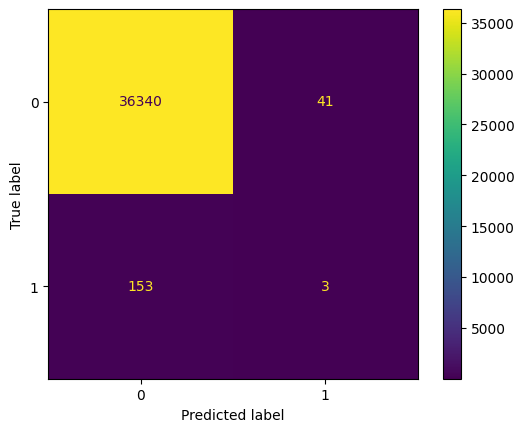

In [22]:
y_pred = gbm.predict(x_test_pca)
y_pred_binary = np.round(y_pred)

accuracy = accuracy_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
auc = roc_auc_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred_binary)

print('Accuracy:', accuracy)
print('Recall:', recall)
print('Precision:', precision)
print('F1 Score:', f1)
print('AUC:', auc)

ConfusionMatrixDisplay(confusion).plot()

In [23]:
from sklearn.metrics import precision_recall_curve, auc, average_precision_score

# Compute precision and recall values
precision, recall, _ = precision_recall_curve(y_test, y_pred)

# Calculate the area under the precision-recall curve (PRAUC)
prauc = auc(recall, precision)

print('PRAUC:', prauc)

ap = average_precision_score(y_test, y_pred)
print('average_precision_score', ap)

PRAUC: 0.043278200154259594
average_precision_score 0.044467797461178855


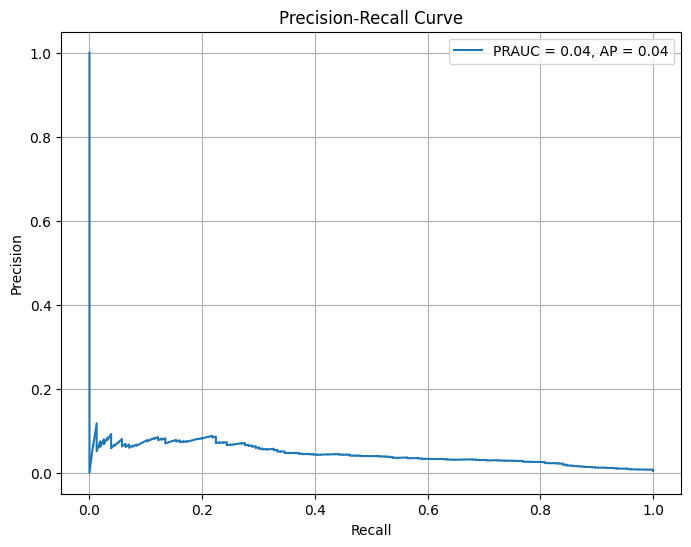

In [24]:
# Calculate the Average Precision (AP) to display in the plot
ap = average_precision_score(y_test, y_pred)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PRAUC = {prauc:.2f}, AP = {ap:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

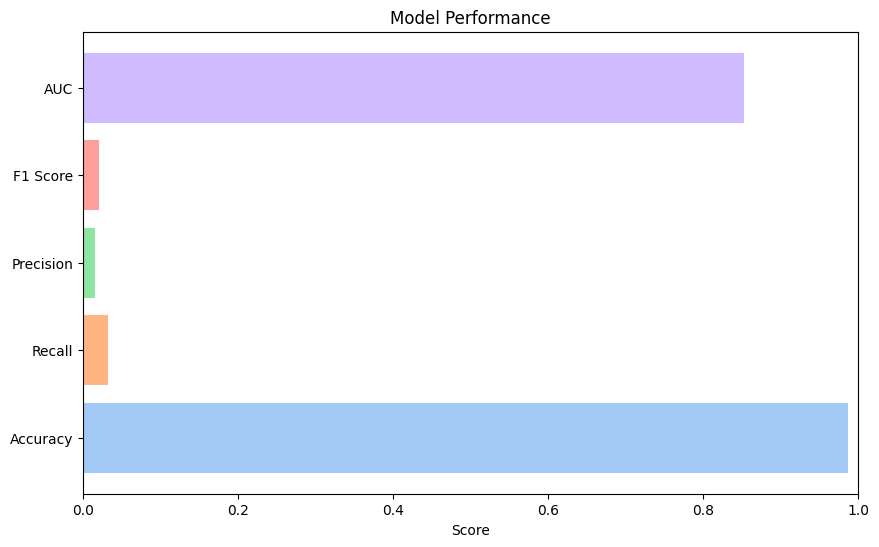

In [19]:
metrics = ['Accuracy', 'Recall', 'Precision', 'F1 Score', 'AUC']
values = [accuracy, recall, precision, f1, auc]
colors = sns.color_palette('pastel', len(metrics))

plt.figure(figsize=(10, 6))
plt.barh(metrics, values, color=colors)
plt.xlabel('Score')
plt.title('Model Performance')
plt.xlim(0, 1)
plt.show()

In [20]:
lst = range(0, len(x_train_pca[0]))
lst_str = [format(x, '02d') for x in lst]
importance = pd.DataFrame({'feature': lst_str ,'importance': gbm.feature_importance()})
importance = importance.sort_values('importance', ascending=False)
print(importance)

   feature  importance
4       04         167
2       02         161
5       05         102
30      30          90
7       07          88
8       08          87
3       03          85
0       00          79
6       06          78
1       01          77
25      25          76
22      22          73
18      18          67
24      24          64
20      20          59
29      29          57
12      12          54
23      23          54
19      19          52
11      11          51
26      26          49
9       09          46
27      27          46
28      28          46
17      17          39
10      10          34
15      15          34
21      21          26
13      13          25
14      14          18
16      16          16


c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


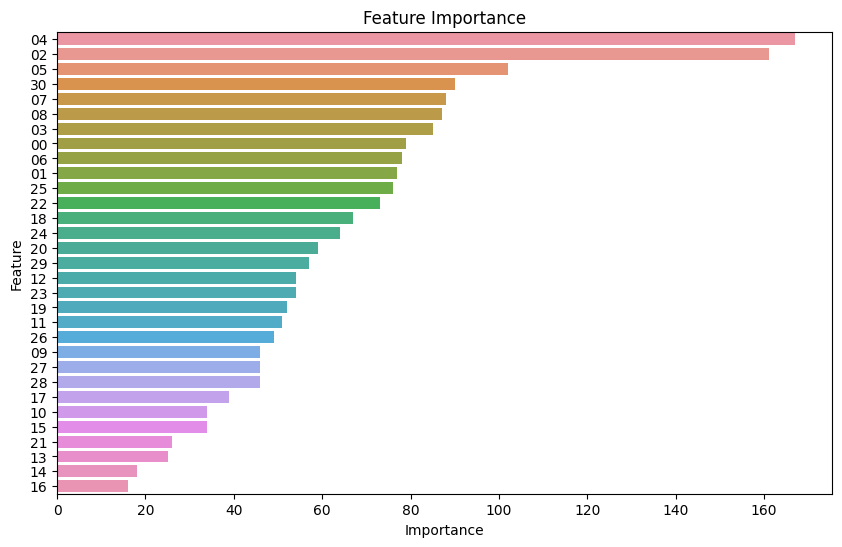

In [21]:
feature_importance = gbm.feature_importance()
features = lst_str
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.sort_values(by='Importance', ascending=False))
plt.title('Feature Importance')
plt.show()

c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.

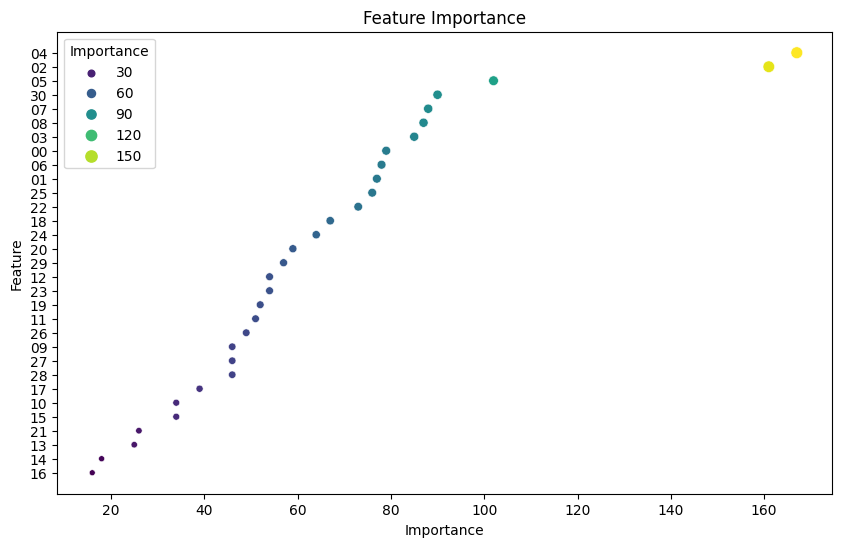

In [22]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Importance', y='Feature', data=importance_df.sort_values(by='Importance', ascending=False), size='Importance', hue='Importance', palette='viridis')
plt.title('Feature Importance')
plt.show()

In [23]:
#AUC OPTIMIZED PCA
results = pd.DataFrame({'Recall': [recall], 'Precision': [precision], 'F1 Score': [f1], 'AUC': [auc]})
results.to_csv(path + 'LGB_PCA_factors_results_aucoptimized.csv', index=False)

best_params_df = pd.DataFrame(best_params, index=[0])
best_params_df.to_csv(path + 'best_params_lgb_PCAfactors_aucoptimized.csv', index=False)

gbm.save_model(path + 'model_lgb_PCAfactors_aucoptimized.txt')